# Brief performance tests of  CPUs vs GPU with TensorFlow

1. Prepare the notebook
1. Confirm TensorFlow can see the GPU
1. Observe TensorFlow speedup on GPU relative to CPU
1. Plot results


Note, deploy this notebook using an Open Data Hub TensorFlow GPU image.

## Prepare the notebook

### Create a symlink for the missing library
This is a temporary workaround specific to CUDA 10.2 on stormshift with Open Data Hub 0.7.0 issues

In [36]:
! test ! -f /opt/app-root/lib64/libcudart.so.10.1 && ln -s /usr/local/cuda/lib64/libcudart.so.10.2 /opt/app-root/lib64/libcudart.so.10.1

### Install tensorflow-gpu 2.2.0, Pandas and Numpy

In [39]:
!pip install tensorflow-gpu==2.2.0
!pip install -U pandas
!pip install -U numpy

You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /opt/app-root/lib/python3.6/site-packages (1.1.1)
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: numpy in /opt/app-root/lib/python3.6/site-packages (1.19.1)
You should consider upgrading via the 'pip install --upgrade pip' command.


## Confirm TensorFlow can see the GPU

In [40]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [38]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Observe TensorFlow speedup on GPU relative to CPU

This example constructs a typical convolutional neural network layer over a
random image and manually places the resulting ops on either the CPU or the GPU
to compare execution speed.

For futher information on convolutional neural networks see [Building a Convolutional Neural Network in Keras: A Brief Primer]( https://missinglink.ai/guides/keras/keras-conv2d-working-cnn-2d-convolutions-keras/)

In [31]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print( '\nThis error most likely means that this notebook is not configured to use a GPU')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
print('CPU and GPU warming ...')
cpu()
gpu()



CPU and GPU warming ...


<tf.Tensor: shape=(), dtype=float32, numpy=-4534.1733>

## Runs tests
Measure the time to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel).
The test runs 10 times.

In [32]:
cpu_time_list = []
gpu_time_list = []
for x in range(10):
    cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
    cpu_time_list.append(cpu_time)
    gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
    gpu_time_list.append(gpu_time)
    print('{0:} - CPU: {1:5.2f}, GPU: {2:5.2f}, Factor:{3:}'.format(x, cpu_time, gpu_time, int(cpu_time/gpu_time)))
    
    

0 - CPU:  4.95, GPU:  0.20, Factor:24
1 - CPU:  5.40, GPU:  0.21, Factor:26
2 - CPU:  5.00, GPU:  0.22, Factor:23
3 - CPU:  5.17, GPU:  0.20, Factor:25
4 - CPU:  5.01, GPU:  0.22, Factor:22
5 - CPU:  5.07, GPU:  0.18, Factor:28
6 - CPU:  5.42, GPU:  0.17, Factor:31
7 - CPU:  5.03, GPU:  0.18, Factor:27
8 - CPU:  5.32, GPU:  0.18, Factor:30
9 - CPU:  5.13, GPU:  0.25, Factor:20


## Plot results

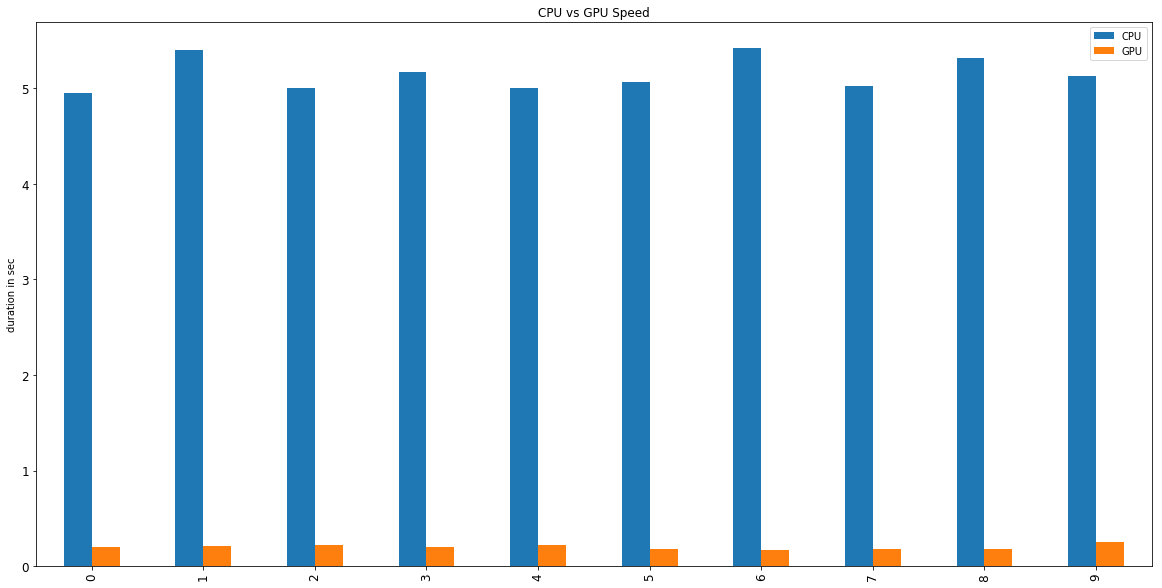

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame(data={'CPU': cpu_time_list, 'GPU': gpu_time_list})
df.plot(fontsize=12,figsize=(20,10),kind='bar', title='CPU vs GPU Speed', ylabel='duration in sec')